## Imports & Initializations

In [1]:
import os
import pickle
import json
import random
import numpy as np
%pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
%pip install torch_geometric -q
import torch_geometric
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import warnings
from torch.utils.data import DataLoader, Dataset
from torch_geometric.nn import GCNConv
from torch.utils.data.dataloader import default_collate
from torch.utils.data import random_split
import math
from torch_geometric.utils import to_dense_adj, add_self_loops
from torch_geometric.nn import global_mean_pool
import time
from sklearn.model_selection import train_test_split

# from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# set seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
warnings.filterwarnings("ignore")
DATA_PATH = "done"

## Dataset Structure

In [3]:
def get_files_in_folder(input_folder):
    file_list = []
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if os.path.isfile(file_path):
            file_list.append(file_path)
    return file_list

# Example usage:
folder_path = 'done'
verilog_files = get_files_in_folder(folder_path)
print(len(verilog_files))
print(verilog_files)

387
['done\\adder10_synth.txt', 'done\\adder11_synth.txt', 'done\\adder12_synth.txt', 'done\\adder13_synth.txt', 'done\\adder14_synth.txt', 'done\\adder15_synth.txt', 'done\\adder16_synth.txt', 'done\\adder17_synth.txt', 'done\\adder18_synth.txt', 'done\\adder19_synth.txt', 'done\\adder1_synth.txt', 'done\\adder20_synth.txt', 'done\\adder21_synth.txt', 'done\\adder22_synth.txt', 'done\\adder23_synth.txt', 'done\\adder24_synth.txt', 'done\\adder25_synth.txt', 'done\\adder26_synth.txt', 'done\\adder27_synth.txt', 'done\\adder28_synth.txt', 'done\\adder2_synth.txt', 'done\\adder3_synth.txt', 'done\\adder4_synth.txt', 'done\\adder5_synth.txt', 'done\\adder6_synth.txt', 'done\\adder7_synth.txt', 'done\\adder8_synth.txt', 'done\\adder9_synth.txt', 'done\\and10_gate_synth.txt', 'done\\and11_gate_synth.txt', 'done\\and12_gate_synth.txt', 'done\\and13_synth.txt', 'done\\and14_synth.txt', 'done\\and15_synth.txt', 'done\\and16_synth.txt', 'done\\and17_synth.txt', 'done\\and18_gate_synth.txt', 'do

In [4]:
def extracting_attributes(verilog_file):
    try:
        if os.path.isfile(verilog_file):
            with open(verilog_file, "r") as file:
                loaded_data = json.load(file)
                nodes = loaded_data[0]
                edges = loaded_data[1]
                label = loaded_data[2]
                
                x = torch.tensor(nodes, dtype=torch.float)
                edge_index = torch.tensor(edges, dtype=torch.long)
                y = torch.tensor(label, dtype=torch.float)
                num_nodes = x.size(0)
                
                # Create batch assignment vector (assuming one graph per file)
                batch = torch.zeros(num_nodes, dtype=torch.long)
                data = Data(x=x, edge_index=edge_index, y = y, batch = batch)
                return data
    
    except Exception as e:
        print(e)
        return e

# temp=extracting_attributes("./done/adder6.txt")
# temp

In [5]:
class VerilogDataset(Dataset):  # Using Dataset from torch_geometric
    def __init__(self, verilog_files):
        print(f"Loaded {len(verilog_files)} Verilog files.")
        self.verilog_files = verilog_files

    def __len__(self):
        return len(self.verilog_files)

    def __getitem__(self, idx):
        verilog_file = self.verilog_files[idx]
        data = extracting_attributes(verilog_file)
        return data

dataset = VerilogDataset(verilog_files)
print(len(dataset))

Loaded 387 Verilog files.
387


In [6]:
print(dataset[0])
print(verilog_files[0])
print(dataset.verilog_files[0])

Data(x=[54, 7], edge_index=[2, 72], y=[1, 15], batch=[54])
done\adder10_synth.txt
done\adder10_synth.txt


In [7]:
def are_all_data_objects_unique(dataset):
    data_objects = []
    for data in dataset:
        if data in data_objects:
            return False
        data_objects.append(data)
    return True

# Example usage:
is_unique = are_all_data_objects_unique(dataset)
if is_unique:
    print("All data objects are unique.")
else:
    print("Duplicate data objects found.")


All data objects are unique.


In [8]:
num = random.randint(0, len(verilog_files))
verilog_files[num]

'done\\sub8_synth.txt'

30


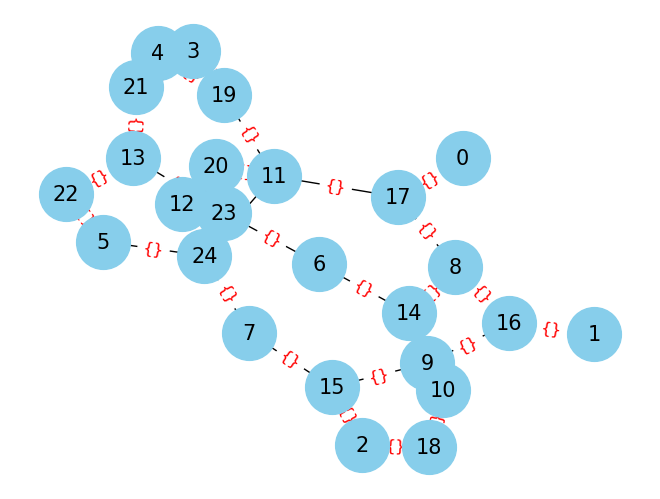

In [9]:
data = dataset[num]
data

g = nx.Graph()
g.add_nodes_from(range(data.num_nodes))
edges = data.edge_index.t().tolist()
# edge_attrs = {tuple(edge): attr.item() for edge, attr in zip(edges, data.edge_attr)}
g.add_edges_from(edges)
print(len(edges))

# Draw the graph with edge attributes
pos = nx.spring_layout(g)  # positions for all nodes
nx.draw(g, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='k', linewidths=1, font_size=15)
nx.draw_networkx_edge_labels(g, pos, font_color='red', font_size=12)  # Add edge labels
plt.show()

In [10]:
def custom_collate(batch):
    if isinstance(batch[0], Data):
        return batch
    else:
        return default_collate(batch)
    


In [11]:
dataset[0].y

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

CHECK THIS TANYY

In [12]:
y_labels = []
for data in dataset:
    # print(data)
    # print(data.y.tolist())
    y_labels.append(np.argmax(data.y.tolist()))

In [13]:
len(y_labels)

387

In [101]:
X_train, X_test, y_train, y_test = train_test_split(dataset, y_labels, test_size=0.2, stratify = y_labels, random_state=41)
train_loader = DataLoader(X_train, batch_size=16, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(X_test, batch_size=16, collate_fn=custom_collate)

In [15]:
# len(train_loader.dataset)
print(train_loader.dataset[0])

Data(x=[57, 7], edge_index=[2, 69], y=[1, 15], batch=[57])


In [16]:
loader_iter = iter(train_loader)
batch = next(loader_iter)
# print(batch)
# print(batch.num_graphs)

In [25]:
# from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool, global_sort_pool
from torch_geometric.nn import GCNConv, JumpingKnowledge, global_mean_pool
import torch.nn.functional as F
import torch.nn as nn
import torch


# class GCN(torch.nn.Module):
#     def __init__(self):
#         super(GCN, self).__init__()
        
#         num_node_features = 7
#         num_output_classes = 15
        
#         self.conv1 = GCNConv(num_node_features, 64)
#         self.conv2 = GCNConv(64, 64)
        
#         self.jk = JumpingKnowledge(mode='cat')
        
#         self.conv3 = GCNConv(128, 128)
#         self.linear = nn.Linear(128, num_output_classes)  # Adjust the input size based on JK mode
        
#     def forward(self, x, edge_index, batch):
#         x1 = F.relu(self.conv1(x, edge_index))
#         x2 = F.relu(self.conv2(x1, edge_index))
#         # x3 = F.relu(self.conv3(x2, edge_index))
        
#         # x = self.jk([x1, x2])
#         x = F.dropout(x, p=0.2, training=self.training)
#         x = self.conv3(x, edge_index)
        
#         x = F.relu(x)
        
#         x = global_mean_pool(x, batch)
        
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.linear(x)
        
#         probs = F.softmax(x, dim=-1)
        
#         return probs
        
        
        
        # KNN
        # embeddings
        # PCA

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        
        num_node_features = 7
        num_output_classes = 15
        
        # num_channels = 32
        
        self.gcn1 = GCNConv(num_node_features, 64)
        self.r1 = nn.ReLU()
        self.gcn2 = GCNConv(64, 128)
        # self.r2 = nn.ReLU()
        # self.gcn3 = GCNConv(64, 128)
        # self.r3 = nn.ReLU()
        # self.gcn4 = GCNConv(128, 128)
        self.linear = nn.Linear(in_features=128, out_features=num_output_classes)
        self.embeddings = []
    def forward(self, x, edge_index, batch):
    
        x = self.gcn1(x, edge_index)
        x = self.r1(x)
        x = self.gcn2(x, edge_index)
        self.embeddings = x
        # x = self.r2(x)
        # x = self.gcn3(x, edge_index)
        
        # x = self.r3(x)
        # x = self.gcn4(x, edge_index)
        x = global_mean_pool(x, batch)
        
        x = F.dropout(x, p = 0.6, training=self.training)
        x = self.linear(x)
        
        probs = F.softmax(x, dim=-1)
        
        return probs, self.embeddings
    
GCN()

GCN(
  (gcn1): GCNConv(7, 64)
  (r1): ReLU()
  (gcn2): GCNConv(64, 128)
  (linear): Linear(in_features=128, out_features=15, bias=True)
)

In [27]:
out_prob = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gcn = GCN()
gcn = gcn.to(device)
# print(gcn.parameters())
# optimizer
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.001, weight_decay=0.0005)
# loss
criterion = torch.nn.CrossEntropyLoss()

out_labels = []

# training_running_loss = 0.0
global embeddings
embeddings = []

def train(train_loader):
    
    gcn.train()
    # print(gcn.parameters())
    for batch_data in train_loader:  # Iterate in batches over the training dataset.
        for data in batch_data:
            optimizer.zero_grad()
            data = data.to(device)
            #forward pass
            out, embeddings = gcn(data.x, data.edge_index, data.batch)
            out_labels.append(out)
            # print(out)
            # calculate the loss
            loss = criterion(out, data.y)
            # zero the gradients of the weights so that the gradients are not accumulated
            # calculate the gradients using backpropagation
            loss.backward()
            # update the weights
            optimizer.step()
            
            # calculate the loss
            # training_running_loss += loss.detach().item()
            
            out_labels.append((out, data.y))
        out_prob.append(out)
        
        

testing_labels = []
def test(loader):
    gcn.eval()
    correct = 0
    for batch_data in loader:  # Iterate in batches over the training/test dataset.
        for data in batch_data:
            out, _ = gcn(data.x, data.edge_index, data.batch)  
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            testing_labels.append(pred)
            y_label = (data.y.tolist())
            y_label = y_label[0].index(1.0)
            pred_label = (pred.tolist())[0]
            # print(pred_label)
            # print(y_label)
            if y_label == pred_label:
                correct += 1            
            # correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


# Start the timer
start_time = time.time()

num_epochs = 100
# Your training code here
for epoch in range(num_epochs):
    train(train_loader)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch + 1:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    

# End the timer
end_time = time.time()

# Calculate the duration
duration = end_time - start_time
print("Training duration:", duration, "seconds")
# with open("out_labels.txt", "w") as output:
#         output.write(str(out_labels))

Epoch: 001, Train Acc: 0.2039, Test Acc: 0.2051
Epoch: 002, Train Acc: 0.1877, Test Acc: 0.1795
Epoch: 003, Train Acc: 0.2362, Test Acc: 0.2308
Epoch: 004, Train Acc: 0.2589, Test Acc: 0.2692
Epoch: 005, Train Acc: 0.2427, Test Acc: 0.2308
Epoch: 006, Train Acc: 0.3074, Test Acc: 0.2564
Epoch: 007, Train Acc: 0.3172, Test Acc: 0.2179
Epoch: 008, Train Acc: 0.3204, Test Acc: 0.2308
Epoch: 009, Train Acc: 0.3463, Test Acc: 0.2308
Epoch: 010, Train Acc: 0.3333, Test Acc: 0.2308
Epoch: 011, Train Acc: 0.3236, Test Acc: 0.2821
Epoch: 012, Train Acc: 0.3916, Test Acc: 0.3333
Epoch: 013, Train Acc: 0.3948, Test Acc: 0.2949
Epoch: 014, Train Acc: 0.3560, Test Acc: 0.2821
Epoch: 015, Train Acc: 0.4304, Test Acc: 0.3205
Epoch: 016, Train Acc: 0.4531, Test Acc: 0.3718
Epoch: 017, Train Acc: 0.4822, Test Acc: 0.4103
Epoch: 018, Train Acc: 0.4725, Test Acc: 0.4359
Epoch: 019, Train Acc: 0.4757, Test Acc: 0.3846
Epoch: 020, Train Acc: 0.4919, Test Acc: 0.4231
Epoch: 021, Train Acc: 0.4951, Test Acc:

In [28]:
out_labels

[tensor([[0.0610, 0.0609, 0.0730, 0.0788, 0.0735, 0.0757, 0.0534, 0.0705, 0.0718,
          0.0557, 0.0578, 0.0669, 0.0585, 0.0766, 0.0660]],
        grad_fn=<SoftmaxBackward0>),
 (tensor([[0.0610, 0.0609, 0.0730, 0.0788, 0.0735, 0.0757, 0.0534, 0.0705, 0.0718,
           0.0557, 0.0578, 0.0669, 0.0585, 0.0766, 0.0660]],
         grad_fn=<SoftmaxBackward0>),
  tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])),
 tensor([[0.0581, 0.0768, 0.0746, 0.0700, 0.0805, 0.0720, 0.0584, 0.0674, 0.0596,
          0.0603, 0.0577, 0.0622, 0.0707, 0.0670, 0.0646]],
        grad_fn=<SoftmaxBackward0>),
 (tensor([[0.0581, 0.0768, 0.0746, 0.0700, 0.0805, 0.0720, 0.0584, 0.0674, 0.0596,
           0.0603, 0.0577, 0.0622, 0.0707, 0.0670, 0.0646]],
         grad_fn=<SoftmaxBackward0>),
  tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])),
 tensor([[0.0634, 0.0758, 0.0669, 0.0638, 0.0643, 0.0798, 0.0591, 0.0650, 0.0597,
          0.0584, 0.0603, 0.0685, 0.0723, 0.07

In [29]:
torch.save(gcn.state_dict(), 'gcn_model55-52-0001-100.pth')

In [128]:
# from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool, global_sort_pool
from torch_geometric.nn import GCNConv, JumpingKnowledge, global_mean_pool
import torch.nn.functional as F
import torch.nn as nn
import torch


# class GCN(torch.nn.Module):
#     def __init__(self):
#         super(GCN, self).__init__()
        
#         num_node_features = 7
#         num_output_classes = 15
        
#         self.conv1 = GCNConv(num_node_features, 64)
#         self.conv2 = GCNConv(64, 64)
        
#         self.jk = JumpingKnowledge(mode='cat')
        
#         self.conv3 = GCNConv(128, 128)
#         self.linear = nn.Linear(128, num_output_classes)  # Adjust the input size based on JK mode
        
#     def forward(self, x, edge_index, batch):
#         x1 = F.relu(self.conv1(x, edge_index))
#         x2 = F.relu(self.conv2(x1, edge_index))
#         # x3 = F.relu(self.conv3(x2, edge_index))
        
#         # x = self.jk([x1, x2])
#         x = F.dropout(x, p=0.2, training=self.training)
#         x = self.conv3(x, edge_index)
        
#         x = F.relu(x)
        
#         x = global_mean_pool(x, batch)
        
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.linear(x)
        
#         probs = F.softmax(x, dim=-1)
        
#         return probs
        
        
        
        # KNN
        # embeddings
        # PCA

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        
        num_node_features = 7
        num_output_classes = 15
        
        # num_channels = 32
        
        self.gcn1 = GCNConv(num_node_features, 64)
        self.r1 = nn.ReLU()
        self.gcn2 = GCNConv(64, 128)

        self.linear = nn.Linear(in_features=128, out_features=num_output_classes)
        
    def forward(self, x, edge_index, batch):
    
        x = self.gcn1(x, edge_index)
        x = self.r1(x)
        x = self.gcn2(x, edge_index)
        
        x_temp = global_mean_pool(x, batch)
        
        
        x = F.dropout(x_temp, p = 0.7, training=self.training)
        x = self.linear(x)
        
        probs = F.softmax(x, dim=-1)
        
        return probs, x_temp
    
GCN()

GCN(
  (gcn1): GCNConv(7, 64)
  (r1): ReLU()
  (gcn2): GCNConv(64, 128)
  (linear): Linear(in_features=128, out_features=15, bias=True)
)

In [129]:
out_prob = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gcn = GCN()
gcn = gcn.to(device)
# print(gcn.parameters())
# optimizer
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.001, weight_decay=0.0005)
# loss
criterion = torch.nn.CrossEntropyLoss()

out_labels = []

# training_running_loss = 0.0
def train(train_loader, embeddings):
    
    gcn.train()
    # print(gcn.parameters())
    for batch_data in train_loader:  # Iterate in batches over the training dataset.
        for data in batch_data:
            optimizer.zero_grad()
            data = data.to(device)
            #forward pass
            out, e = gcn(data.x, data.edge_index, data.batch)
            embeddings.append(e)
            out_labels.append(out)
            # print(out)
            # calculate the loss
            loss = criterion(out, data.y)
            # zero the gradients of the weights so that the gradients are not accumulated
            # calculate the gradients using backpropagation
            loss.backward()
            # update the weights
            optimizer.step()
            
            # calculate the loss
            # training_running_loss += loss.detach().item()
            
            out_labels.append((out, data.y))
        out_prob.append(out)
        
        return embeddings

testing_labels = []
def test(loader):
    gcn.eval()
    correct = 0
    for batch_data in loader:  # Iterate in batches over the training/test dataset.
        for data in batch_data:
            out, _ = gcn(data.x, data.edge_index, data.batch)  
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            testing_labels.append(pred)
            y_label = (data.y.tolist())
            y_label = y_label[0].index(1.0)
            pred_label = (pred.tolist())[0]
            # print(pred_label)
            # print(y_label)
            if y_label == pred_label:
                correct += 1            
            # correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


# Start the timer
start_time = time.time()

num_epochs = 150
# Your training code here
for epoch in range(num_epochs):
    embeddings = []
    embeddings = train(train_loader, embeddings)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch + 1:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    

# End the timer
end_time = time.time()

# Calculate the duration
duration = end_time - start_time
print("Training duration:", duration, "seconds")
# with open("out_labels.txt", "w") as output:
#         output.write(str(out_labels))

Epoch: 001, Train Acc: 0.0809, Test Acc: 0.0769
Epoch: 002, Train Acc: 0.0809, Test Acc: 0.0769
Epoch: 003, Train Acc: 0.0809, Test Acc: 0.0769
Epoch: 004, Train Acc: 0.0809, Test Acc: 0.0769
Epoch: 005, Train Acc: 0.0809, Test Acc: 0.0769
Epoch: 006, Train Acc: 0.0809, Test Acc: 0.0769
Epoch: 007, Train Acc: 0.1100, Test Acc: 0.1410
Epoch: 008, Train Acc: 0.1327, Test Acc: 0.1410
Epoch: 009, Train Acc: 0.1456, Test Acc: 0.1282
Epoch: 010, Train Acc: 0.1036, Test Acc: 0.1026
Epoch: 011, Train Acc: 0.0906, Test Acc: 0.0897
Epoch: 012, Train Acc: 0.0777, Test Acc: 0.0769
Epoch: 013, Train Acc: 0.1392, Test Acc: 0.1154
Epoch: 014, Train Acc: 0.1553, Test Acc: 0.1538
Epoch: 015, Train Acc: 0.1489, Test Acc: 0.1410
Epoch: 016, Train Acc: 0.1392, Test Acc: 0.1154
Epoch: 017, Train Acc: 0.2006, Test Acc: 0.1667
Epoch: 018, Train Acc: 0.2039, Test Acc: 0.1667
Epoch: 019, Train Acc: 0.2168, Test Acc: 0.1795
Epoch: 020, Train Acc: 0.2071, Test Acc: 0.1795
Epoch: 021, Train Acc: 0.2071, Test Acc:

In [54]:
torch.save(gcn.state_dict(), 'gcn_model34-33-0001-150.pth')

In [133]:
with torch.no_grad():
    gcn.eval()
    train_embeddings = []
    test_embeddings = []
    
    for data in X_train:
        res, res2 = gcn(data.x, data.edge_index, data.batch)
        res2 = res2.detach().numpy()
        # res2_flat = [item for sublist in res2 for item in sublist]
        # print(len(data.x))
        # print(len(res2[0]))
        # print(len(res2_flat))
        train_embeddings.append(res2[0])
    
    for data in X_test:
        res, res2 = gcn(data.x, data.edge_index, data.batch)
        res2 = res2.detach().numpy()
        test_embeddings.append(res2[0])

# Use node embeddings as features for classical ML model (e.g., logistic regression)
X_train_em, y_train = train_embeddings, y_train
X_test_em, y_test = test_embeddings, y_test

In [136]:
for x in X_train_em:
    if len(x) != 128:
        print(len(x))
        
for x in X_test_em:
    if len(x) != 128:
        print(len(x))

In [137]:
from sklearn.decomposition import PCA

pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train_em)
X_test_pca = pca.transform(X_test_em)

In [138]:
for x in X_train_pca:
    if len(x) != 7:
        print(len(x))

In [139]:
len(X_train_pca)

309

In [140]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Train KNN classifier on PCA-transformed data
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_pca, y_train)

# Evaluate KNN classifier on test set
y_pred = knn_classifier.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6538461538461539


In [141]:
import joblib
joblib.dump(knn_classifier, 'knn_model_embeddings_pca_65.pkl')

KNN_loaded_model = joblib.load('knn_model_embeddings_pca_65.pkl')

In [143]:
# num = random.randint(0, len(verilog_files))
# print(verilog_files[num])
output_dict = dict()
for data_trial in test_loader.dataset:
    
    out,_ = gcn(data_trial.x, data_trial.edge_index, data_trial.batch)
    pred = out.argmax(dim=1)
    
    if pred.tolist()[0] != (data_trial.y.tolist())[0].index(1.0):
        output_dict[(pred.tolist()[0], (data_trial.y.tolist())[0].index(1.0))] = output_dict.get((pred.tolist()[0], (data_trial.y.tolist())[0].index(1.0)), 0) +1
        # print(pred.tolist())
        # print((data_trial.y.tolist())[0].index(1.0))


output_dict
        

{(11, 12): 6,
 (13, 11): 2,
 (0, 5): 2,
 (8, 9): 1,
 (0, 3): 1,
 (0, 7): 2,
 (0, 2): 6,
 (11, 1): 3,
 (8, 3): 1,
 (0, 14): 6,
 (13, 5): 2,
 (0, 13): 5,
 (8, 6): 4,
 (0, 4): 6,
 (8, 0): 1,
 (13, 3): 1,
 (9, 3): 2,
 (8, 5): 2,
 (13, 2): 1,
 (0, 1): 1}

In [17]:
# gcn = GCN()
# gcn.load_state_dict(torch.load('gcn_model85-59-0001-200.pth'))



<All keys matched successfully>

## Experiment 1


### Mode of Operation

* 321 verilog files 
* only 3 features             [type, operation_type, num_of_connections]
* no edge attribute
* 18 classes 
* 200 epochs 
* learning rate = 0.01
* Dropoout = 0.4
* Adam Optimizer
* train 70, test 30 (on whole dataset, not each class)
* time of training = seconds


### Results

* Train acc:  0.2902
* Test Acc: 0.1959


### Suggested Modifications for upcoming experiments

1) Clean dataset (by removing unnecessay, uninformative or wrong code files)
2) remove reduntant parsing (different files but same parsing)
3) include more informative features
4) improve encoding format
5) try using less classes (most important ones, so that less classes but more balanced dataset)
6) adding more files
7) adjusting hyperparameters such as learning rate, dropout, ...etc
8) splitting train, val, test
9) using equal percentages of each class (adjusting splitting)

## Experiment 2

### Mode of Operation

### Results

### Suggested Modifications for upcoming experiments

# Experiment 5

lr = 0.001

droput 0.4

314 files

17 features (node_type)

16 classes

conv relu conv relu conv relu conv linear

train = 40, test = 27

200 epochs


# experiment 6 

same as 5 but 100 epochs

train = 43, test = 25

# Experiment 7

lr = 0.001

conv relu conv relu conv dropout linear

9 classes

164 file

train = 34, test = 26

# Experiment 8

lr = 0.001

9 classes

conv relu conv relu conv dropout linear 

train = 64, test = 52

164 

17 features (node type)
